In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the data
data = pd.read_csv("titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# let us see how many null values are present in each column

null_counts = data.isnull().sum()
null_counts

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# let us see how many unique tickets there are

unique_tickets = data['Ticket'].nunique()
unique_tickets

681

In [5]:
# let us drop some useless columns

data_without_columns = data.drop(['PassengerId','Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Fare'], axis = 1)
data_without_columns.head()

,Survived,Pclass,Sex,Age
0,0,3,male,22.0
1,1,1,female,38.0
2,1,3,female,26.0
3,1,1,female,35.0
4,0,3,male,35.0


In [6]:
# since age has a lot of missing values we can replace it with 

data_without_columns['Age'] = data_without_columns['Age'].fillna(data_without_columns['Age'].mean())
data_without_columns.head()

,Survived,Pclass,Sex,Age
0,0,3,male,22.0
1,1,1,female,38.0
2,1,3,female,26.0
3,1,1,female,35.0
4,0,3,male,35.0


In [7]:
data_encoded = pd.get_dummies(data_without_columns, drop_first=True)
data_encoded.head()

,Survived,Pclass,Age,Sex_male
0,0,3,22.0,True
1,1,1,38.0,False
2,1,3,26.0,False
3,1,1,35.0,False
4,0,3,35.0,True


In [8]:
# let us shuffle the data

data_shuffled = data_encoded.sample(frac = 1)
data_shuffled.head()

,Survived,Pclass,Age,Sex_male
559,1,3,36.000000,False
732,0,2,29.699118,True
70,0,2,32.000000,True
352,0,3,15.000000,True
178,0,2,30.000000,True


In [9]:
# let us define X and Y

X = data_shuffled.drop('Survived', axis = 1)
Y = data_shuffled['Survived']
print(X.shape)
print(Y.shape)

(891, 3)
(891,)


In [10]:
# splitting the data into 80% for training and 20% for testing (generally recommended to do 60-80% for training and 10-20% for testing and 10-20% for validation but we are not using validation set here)

split_percent = int(len(X) * 0.8)

X_train = X[:split_percent].values
X_test = X[split_percent:].values
Y_train = Y[:split_percent].values
Y_test = Y[split_percent:].values

In [11]:
# reshaping the matrix

X_train = X_train.T
Y_train = Y_train.reshape(1, X_train.shape[1])

X_test = X_test.T
Y_test = Y_test.reshape(1, X_test.shape[1])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3, 712)
(1, 712)
(3, 179)
(1, 179)


In [12]:

class TitanicSurvivalLogisticRegression:
    def __init__(self, learning_rate= 1, iterations= 1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.w = None
        self.b = 0
        self.losses = []
        
    def sigmoid(self, x):
        x = x.astype(float)
        return 1 / (1 + np.exp(-x))
        
    def gradient_descent(self, X_train, Y_train):

        m = X_train.shape[1] #total number of observations
        n = X_train.shape[0] #total number of features

        self.w = np.zeros((n, 1))
        self.b = 0

        for i in range(self.iterations):
            z = np.dot(self.w.T , X_train) + self.b
            a = self.sigmoid(z) #using this to make predictions
            
            w_derivative = (1 / m) * np.dot((a - Y_train),X_train.T)
            b_derivative = (1 / m) * np.sum(a - Y_train)
            
            self.w = self.w - (self.learning_rate * w_derivative.T)
            self.b = self.b - (self.learning_rate * b_derivative)
            
            loss = -(1/m) * np.sum(Y_train * np.log(a) + (1 - Y_train) * np.log(1 - a)) #loss function
            
            self.losses.append(loss)
            
            if (i%500 == 0):
                print("The iteration is", i, "and loss is", loss)

        return self.w, self.b, self.losses

    def predict(self, X_train, threshold = 0.5):
        X_train_predict = X_train.T
        z = np.dot(X_train_predict, self.w) + self.b
        predictions = self.sigmoid(z)
        survival_predictions = []
        for prob in predictions:
            if prob >= threshold:
                survival_predictions.append(1)  
            else:
                survival_predictions.append(0)
        return np.array(survival_predictions)

    def accuracy(self, y_true, y_pred):
        print(y_true.shape)
        return np.mean(y_true == y_pred)

    def f1_score(self, y_true, y_pred):
        true_positive = np.sum((y_true == 1) & (y_pred == 1))
        false_positive = np.sum((y_true == 0) & (y_pred == 1))
        false_negative = np.sum((y_true == 1) & (y_pred == 0))
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1 = 2 * (precision * recall) / (precision + recall)
        return precision, recall, f1


In [13]:
# let us call the functions

titanic = TitanicSurvivalLogisticRegression(learning_rate = 0.008, iterations = 20000)
w, b, losses = titanic.gradient_descent(X_train, Y_train)
predictions = titanic.predict(X_train, threshold = 0.7) # can use X_test as well
accuracy = titanic.accuracy(Y_train.flatten(), predictions)
print("The accuracy is:", round(accuracy*100,2),"%")
X_test_predict = titanic.predict(X_test, threshold = 0.7)
precision, recall, f1 = titanic.f1_score(Y_test.flatten(), X_test_predict)
print("Precision:", round(precision,4), "Recall:", round(recall,4), "F1:", round(f1,4))

The iteration is 0 and loss is 0.6931471805599453
The iteration is 500 and loss is 0.5984410373849516
The iteration is 1000 and loss is 0.5719381542989481
The iteration is 1500 and loss is 0.5532054050352953
The iteration is 2000 and loss is 0.5393954799101082
The iteration is 2500 and loss is 0.5289698324085054
The iteration is 3000 and loss is 0.5209000010305607
The iteration is 3500 and loss is 0.5144929094687473
The iteration is 4000 and loss is 0.509278810265238
The iteration is 4500 and loss is 0.5049365362428214
The iteration is 5000 and loss is 0.5012441894434516
The iteration is 5500 and loss is 0.4980466670513522
The iteration is 6000 and loss is 0.4952341889574933
The iteration is 6500 and loss is 0.49272800263387806
The iteration is 7000 and loss is 0.49047078984393433
The iteration is 7500 and loss is 0.48842017506001323
The iteration is 8000 and loss is 0.48654429684520606
The iteration is 8500 and loss is 0.4848187630316589
The iteration is 9000 and loss is 0.48322454183

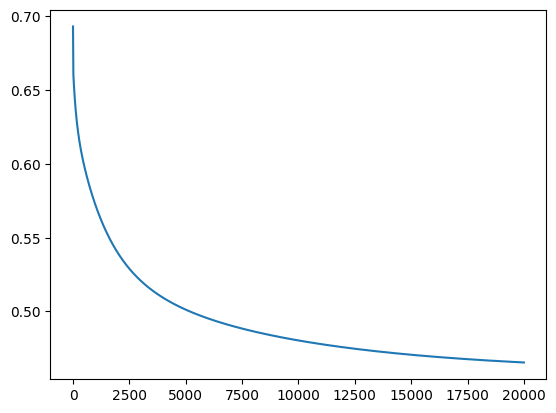

In [14]:
range_iterations = np.arange(0, titanic.iterations)
plt.plot(range_iterations, losses)
plt.show()